<a href="https://colab.research.google.com/github/sachinsharma9780/interactive_tutorials/blob/master/notebooks/Integrate_ArangoDB_with_PyG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrate ArangoDB with PyTorch Geometric to build Recommender Systems using Graph Neural Networks


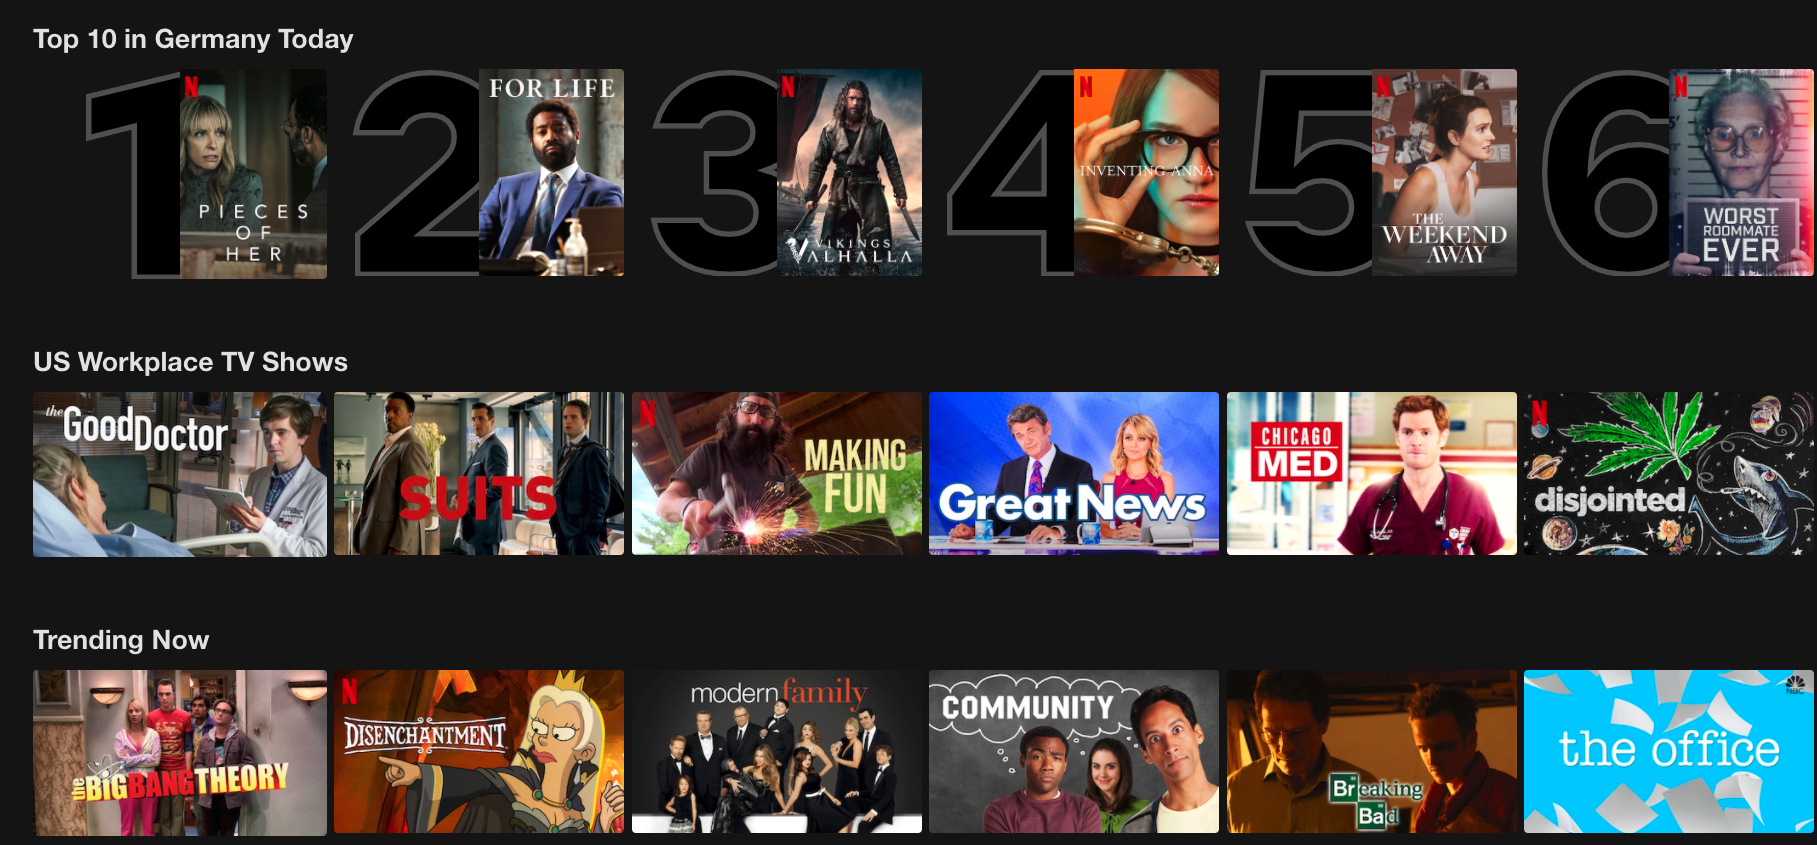

## Introduction

With the advancement of Internet technology, recommendations acted as an integral part of the internet whether we are watching some videos on YouTube, enjoying movies with friends on Netflix, getting new friends suggestion on facebook, online advertisements or Amazon product suggestions all of these scenarios uses recommendation systems at their backend to suggest users an items that could interest them. The main objective of recommendation systems is to suggest a user suitable item based on his/her past behavior of engagements with the items and user's side information (e.g. age, gender, demographics, etc). Therefore, recommender systems (RS) are used to search for the small number of relevant items that match a user's personalized interests. Here, I am assuming a recommender system with no-cold start problem. 

On the other hand, Graph Neural Networks (GNNs) based methods have shown a great success for tackling the recommendation problems when compared to the traditional recommendation technique like collaborative filtering (CF). There are several use cases out there in industry which use GNNs to solve their recommendation problems. For example, **Food Discovery with Uber Eats** Uber uses the power of GNNs to suggest to its users the dishes, restaurants, and cuisines they might like next. To make these recommendations Uber eats uses the [GraphSAGE](https://github.com/williamleif/GraphSAGE) algorithm because of its inductive nature and the power to scale up-to billion of nodes. Another interesting application is [PinSage](https://medium.com/pinterest-engineering/pinsage-a-new-graph-convolutional-neural-network-for-web-scale-recommender-systems-88795a107f48) ( a random-walk Graph Convolutional Network capable of learning embeddings for nodes in web-scale graphs containing billions of objects) an algorithm developed by Pinterest company to perform visual recommendations.



Therefore, in this blogpost, we will together build a complete movie recommendation application using [ArangoDB](https://www.arangodb.com/) (open-source native multi-model graph database) and [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) (library built upon PyTorch to easily write and train custom GNNs). In graph machine learning (or graph neural networks) we solve mainly three types of tasks i.e. node classification, link prediction and graph classification. In this blogpost, we are going to tackle the challenge of building movie recommendation application by transforming it into the task of link prediction. The aim of the link prediction task is to predict whether there is an edge existing between two given nodes. First, we are going to build a bipartite graph of user and movie nodes where an edge between a user and movie represents how much rating (lies between 1-5) the user has given to that movie. Then, our goal is to predict missing links between a user and the movies which he has not watched yet. The missing links are computed with the graph neural networks where we predict the ratings for all the unseen movies. At the end, only those movies are recommended to a user where the predicting ratings are equal to 5. Below figure depicts the bipartite graph of user and movie nodes:




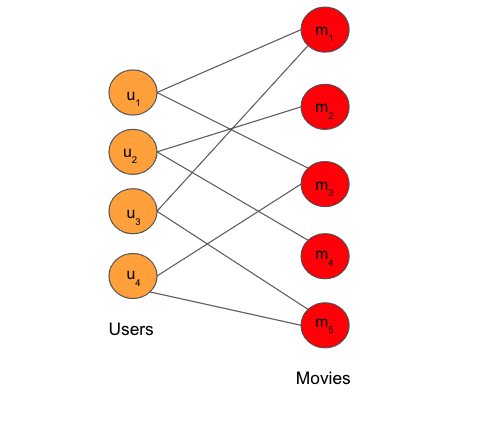

### Outline 


We are going to use [The Movies Dataset ](https://www.kaggle.com/rounakbanik/the-movies-dataset) from Kaggle which contains the metadata for all 45,000 movies listed in the Full MovieLens Dataset. With the help of  metadata information we are going to prepare features for our movie nodes which then can be used as an input for our GNNs. The focus of this blogpost revolves around the following key content:

*   Loading the data present in csv files to ArangoDB (in graph format).
*   Converting the graph present inside the ArangoDB into a PyTorch Geometric (PyG) data object.
*   Train GNN model on this PyG data object.
*   Generate predictions and store them back to ArangoDB.


# N.B. Before you run this notebook!!!

If you are running this notebook on Google Colab, please make sure to enable hardware acceleration using either a GPU or a TPU. If it is run with CPU-only enabled, training GNNs will take an incredibly long time! Hardware acceleration can be enabled by navigating to Runtime -> Change Runtime. This will present you with a popup, where you can select an appropriate Hardware Accelerator

### Let's Start with Installing Necessary Libraries

In [1]:
%%capture
!git clone -b oasis_connector --single-branch https://github.com/arangodb/interactive_tutorials.git
!git clone -b movie-data-source --single-branch https://github.com/arangodb/interactive_tutorials.git movie_data_source
!rsync -av interactive_tutorials/ ./ --exclude=.git
!chmod -R 755 ./tools
!pip install pyarango
!pip install "python-arango>=5.0"
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install sentence-transformers

### Setting up the dataset

We are going to use the sampled version of [The Movies Dataset ](https://www.kaggle.com/rounakbanik/the-movies-dataset). This dataset contains mainly three csv files:

1. movies_metadata.csv: Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.
2. links_small.csv: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.
3. ratings_small.csv: The subset of 100,000 ratings from 700 users on 9,000 movies.



In [ ]:
# unzip movies dataset zip file
!unzip ./movie_data_source/sampled_movie_dataset.zip

### Import Libraries

In [ ]:
import pandas as pd
from arango import ArangoClient
from tqdm import tqdm
import numpy as np
import itertools
import requests
import sys
import oasis
from arango import ArangoClient

import torch
import torch.nn.functional as F
from torch.nn import Linear
from arango import ArangoClient
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from sentence_transformers import SentenceTransformer
from torch_geometric.data import HeteroData
import yaml

# Loading the data present in csv files to ArangoDB

In this section, we will read the data from multiple csv files and construct a graph out of it. The graph which we are going to construct is a bipartite graph having user nodes on the one side and movie nodes on the other side of the graph. In addition to this user and movies nodes of the graph will also be accompanied by their corresponding attributes features. Next, we are going to store this generated graph inside the ArangoDB.

In [ ]:
metadata_path = './sampled_movie_dataset/movies_metadata.csv'
df = pd.read_csv(metadata_path)

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
# on these rows metadata information is missing
df = df.drop([19730, 29503, 35587])

In [ ]:
# sampled from links.csv file
links_small = pd.read_csv('./sampled_movie_dataset/links_small.csv')

In [ ]:
links_small.head()

In [ ]:
# selecting tmdbId coloumn from links_small file
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')


In [ ]:
df['id'] = df['id'].astype('int')

In [ ]:
sampled_md = df[df['id'].isin(links_small)]
sampled_md.shape

In [ ]:
sampled_md['tagline'] = sampled_md['tagline'].fillna('')
sampled_md['description'] = sampled_md['overview'] + sampled_md['tagline']
sampled_md['description'] = sampled_md['description'].fillna('')

In [ ]:
sampled_md = sampled_md.reset_index()

In [ ]:
sampled_md.head()

In [ ]:
indices = pd.Series(sampled_md.index, index=sampled_md['title'])

In [ ]:
ind_gen = pd.Series(sampled_md.index, index=sampled_md['genres'])

### Let's Load Ratings File

We are going to use the ratings file to construct a bipartite graph. This file includes movies rated by different users on the scale of 1-5, rating of 1 implies very bad movie and 5 corresponds to a very good movie.

In [ ]:
ratings_path = './sampled_movie_dataset/ratings_small.csv'

In [ ]:
ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

In [ ]:
# performs user and movie mappings
def node_mappings(path, index_col):
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    return mapping

In [ ]:
user_mapping = node_mappings(ratings_path, index_col='userId')

In [ ]:
movie_mapping = node_mappings(ratings_path, index_col='movieId')

In [ ]:
m_id = ratings_df['movieId'].tolist()

In [ ]:
# all unique movie_ids present inside ratings file
#m_id = list(set(m_id))
m_id = list(dict.fromkeys(m_id))
len(m_id)

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('./sampled_movie_dataset/links_small.csv')[['movieId', 'tmdbId']]


In [ ]:
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)

In [ ]:
id_map.columns = ['movieId', 'id']


In [ ]:
id_map.head()

In [ ]:
# tmbdid is same (of links_small) as of id in sampled_md
id_map = id_map.merge(sampled_md[['title', 'id']], on='id').set_index('title')

In [ ]:
indices_map = id_map.set_index('id')

## ArangoDB Setup

In this section, we first connect to the temporary ArangoDB on cloud using Oasis (our managed service for cloud). Once it is connected, we can then load movies metadata (movie title, genres, description, etc.) and ratings (ratings given by users to movies) information inside ArangoDB collections.

In [ ]:
# get temporary credentials for ArangoDB on cloud
login = oasis.getTempCredentials(tutorialName="MovieRecommendations", credentialProvider="https://tutorials.arangodb.cloud:8529/_db/_system/tutorialDB/tutorialDB")

# Connect to the temp database
# Please note that we use the python-arango driver as it has better support for ArangoSearch 
movie_rec_db = oasis.connect_python_arango(login)

Printing authentication credentials

In [ ]:
# url to access the ArangoDB Web UI
print("https://"+login["hostname"]+":"+str(login["port"]))
print("Username: " + login["username"])
print("Password: " + login["password"])
print("Database: " + login["dbName"])

In [ ]:
# print 5 mappings of movieIds
list(movie_mapping.items())[:5]

In [ ]:
movie_mapping.items()

In [ ]:
print("%d number of unique movie ids" %len(m_id))

In [ ]:
# remove ids which dont have meta data information

def remove_movies(m_id):
    no_metadata = []
    for idx in range(len(m_id)):
        tmdb_id = id_map.loc[id_map['movieId'] == m_id[idx]]
  
        if tmdb_id.size == 0:
            no_metadata.append(m_id[idx])
            #print('No Meta data information at:', m_id[idx])
    return no_metadata

In [ ]:
no_metadata = remove_movies(m_id)

In [ ]:
## remove ids which dont have meta data information
for element in no_metadata:
    if element in m_id:
        print("ids with no metadata information:",element)
        m_id.remove(element)

In [ ]:
print("Number of movies with metadata information:", len(m_id))

In [ ]:
# create new movie_mapping dict with only m_ids having metadata information
movie_mappings = {}
for idx, m in enumerate(m_id):
    movie_mappings[m] = idx

### Loading movies metadata into ArangoDB's Movie collection

In this section, we are going to create a "Movie" collection in ArangoDB where each document of the collection represents a unique movie along with its metadata information.

In [ ]:
# create a new collection named "Movie" if it does not exist.
# This returns an API wrapper for "Movie" collection.
if not movie_rec_db.has_collection("Movie"):
    movie_rec_db.create_collection("Movie", replication_factor=3)

In [ ]:
batch = []
BATCH_SIZE = 128
batch_idx = 1
index = 0
movie_collection = movie_rec_db["Movie"]

In [ ]:
# loading movies metadata information into ArangoDB's Movie collection
for idx in tqdm(range(len(m_id))):
    insert_doc = {}
    tmdb_id = id_map.loc[id_map['movieId'] == m_id[idx]]
  
    if tmdb_id.size == 0:
        print('No Meta data information at:', m_id[idx])
        

    else:
        tmdb_id = int(tmdb_id.iloc[:,1][0])
        emb_id = "Movie/" + str(movie_mappings[m_id[idx]])
        insert_doc["_id"] = emb_id
        m_meta = sampled_md.loc[sampled_md['id'] == tmdb_id]
        # adding movie metadata information 
        m_title = m_meta.iloc[0]['title']
        m_poster = m_meta.iloc[0]['poster_path']
        m_description = m_meta.iloc[0]['description']
        m_language = m_meta.iloc[0]['original_language']
        m_genre = m_meta.iloc[0]['genres']
        m_genre = yaml.load(m_genre, Loader=yaml.BaseLoader)
        genres = [g['name'] for g in m_genre]
         
        insert_doc["movieId"] = m_id[idx]
        insert_doc["mapped_movieId"] = movie_mappings[m_id[idx]]
        insert_doc["tmdbId"] = tmdb_id
        insert_doc['movie_title'] = m_title
     
        insert_doc['description'] = m_description
        insert_doc['genres'] = genres
        insert_doc['language'] = m_language
        
        if str(m_poster) == "nan":
            insert_doc['poster_path'] = "No poster path available"
        else:
            insert_doc['poster_path'] = m_poster
        
        batch.append(insert_doc)
        index +=1
        last_record = (idx == (len(m_id) - 1))
        if index % BATCH_SIZE == 0:
            #print("Inserting batch %d" % (batch_idx))
            batch_idx += 1
            movie_collection.import_bulk(batch)
            batch = []   
        if last_record and len(batch) > 0:
            print("Inserting batch the last batch!")
            movie_collection.import_bulk(batch)

### Creating User Collection in ArangoDB

Since "The Movies Dataset" does not contain any metadata information about users, therefore we are just going to create a user collection with user_ids only.

In [ ]:
# create a new collection named "Users" if it does not exist.
# This returns an API wrapper for "Users" collection.
if not movie_rec_db.has_collection("Users"):
    movie_rec_db.create_collection("Users", replication_factor=3)

In [ ]:
# Users has no side information
total_users = np.unique(ratings_df[['userId']].values.flatten()).shape[0]
print("Total number of Users:", total_users)

In [ ]:
def populate_user_collection(total_users):
    batch = []
    BATCH_SIZE = 50
    batch_idx = 1
    index = 0
    user_ids = list(user_mapping.keys())
    user_collection = movie_rec_db["Users"]
    for idx in tqdm(range(total_users)):
        insert_doc = {}

        insert_doc["_id"] = "Users/" + str(user_mapping[user_ids[idx]])
        insert_doc["original_id"] = str(user_ids[idx])
        
        batch.append(insert_doc)
        index +=1
        last_record = (idx == (total_users - 1))
        if index % BATCH_SIZE == 0:
            #print("Inserting batch %d" % (batch_idx))
            batch_idx += 1
            user_collection.import_bulk(batch)
            batch = []   
        if last_record and len(batch) > 0:
            print("Inserting batch the last batch!")
            user_collection.import_bulk(batch)

In [ ]:
populate_user_collection(total_users)

### Creating Ratings (Edge) Collection

Here, we first create a Ratings (Edge) collection in ArangoDB and then populate this collection with edges of a bipartite graph. Each edge document in this collection will contain the information about _from (user) and _to (movie) node along with the rating data given by a user to that particular movie. Once the creation of this collection is completed, a bipartite graph (user and movie nodes) is formed in ArangoDB which can be viewed using ArangoDB Web UI under the Graphs->movie_rating_graph.

In [ ]:
# create a new collection named "Ratings" if it does not exist.
# This returns an API wrapper for "Ratings" collection.
if not movie_rec_db.has_collection("Ratings"):
    movie_rec_db.create_collection("Ratings", edge=True, replication_factor=3)

In [ ]:
# defining graph schema

# create a new graph called movie_rating_graph in the temp database if it does not already exist.
if not movie_rec_db.has_graph("movie_rating_graph"):
    movie_rec_db.create_graph('movie_rating_graph', smart=True)

# This returns and API wrapper for the above created graphs
movie_rating_graph = movie_rec_db.graph("movie_rating_graph")

In [ ]:
# Create a new vertex collection named "Users" if it does not exist.
if not movie_rating_graph.has_vertex_collection("Users"):
    movie_rating_graph.vertex_collection("Users")

In [ ]:
# Create a new vertex collection named "Movie" if it does not exist.
if not movie_rating_graph.has_vertex_collection("Movie"):
    movie_rating_graph.vertex_collection("Movie")

In [ ]:
# creating edge definitions named "Ratings. This creates any missing
# collections and returns an API wrapper for "Ratings" edge collection.
if not movie_rating_graph.has_edge_definition("Ratings"):
    Ratings = movie_rating_graph.create_edge_definition(
        edge_collection='Ratings',
        from_vertex_collections=['Users'],
        to_vertex_collections=['Movie']
    )

In [ ]:
user_id, movie_id, ratings = ratings_df[['userId']].values.flatten(), ratings_df[['movieId']].values.flatten() , ratings_df[['rating']].values.flatten()

In [ ]:
def create_ratings_graph(user_id, movie_id, ratings):
    batch = []
    BATCH_SIZE = 100
    batch_idx = 1
    index = 0
    edge_collection = movie_rec_db["Ratings"]
    for idx in tqdm(range(ratings.shape[0])):
        
        # removing edges (movies) with no metatdata
        if movie_id[idx] in no_metadata:
            print('Removing edges with no metadata', movie_id[idx])
            
        else:
            insert_doc = {}
            insert_doc = {"_id":    "Ratings" + "/" + 'user-' + str(user_mapping[user_id[idx]]) + "-r-" + "movie-" + str(movie_mappings[movie_id[idx]]), 
                          "_from":  ("Users" + "/" + str(user_mapping[user_id[idx]])),
                          "_to":    ("Movie" + "/" + str(movie_mappings[movie_id[idx]])),
                          "_rating": float(ratings[idx])}

            batch.append(insert_doc)
            index += 1
            last_record = (idx == (ratings.shape[0] - 1))

            if index % BATCH_SIZE == 0:
                #print("Inserting batch %d" % (batch_idx))
                batch_idx += 1
                edge_collection.import_bulk(batch)
                batch = []
            if last_record and len(batch) > 0:
                print("Inserting batch the last batch!")
                edge_collection.import_bulk(batch)

In [ ]:
create_ratings_graph(user_id, movie_id, ratings)

Viusalization of User-Movie-Ratings graph in ArangoDB's Web UI

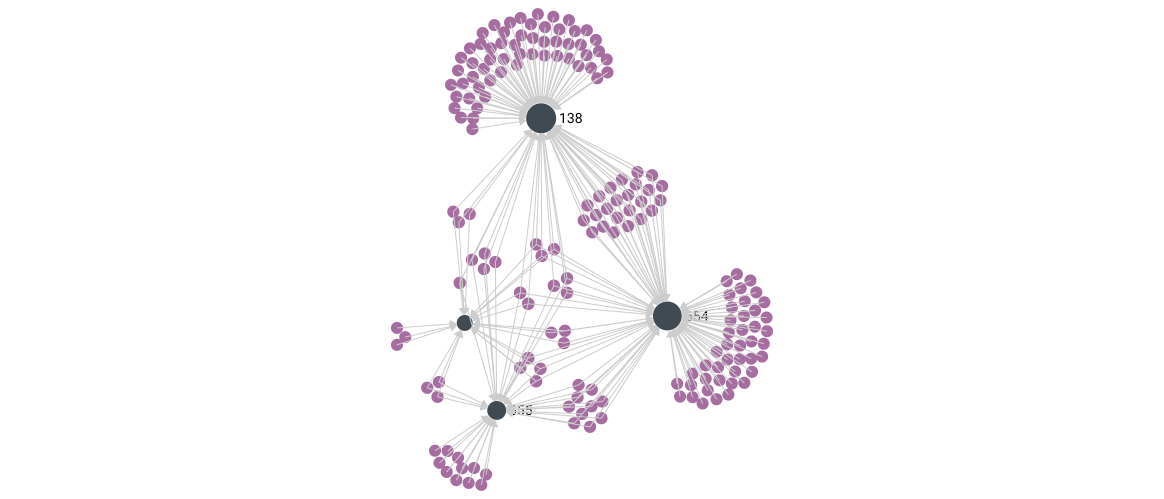

# Converting the Graph present inside the ArangoDB into a PyTorch Geometric (PyG) data object

So far we have seen how to construct a graph from mutiple csv files and load that graph into ArangoDB. The next step would be to export this graph from ArangoDB and construct a heterogeneous PyG graph. 

In [ ]:
# Get API wrappers for collections.
users = movie_rec_db.collection('Users')
movies = movie_rec_db.collection('Movie')
ratings_graph = movie_rec_db.collection('Ratings')

In [ ]:
len(users), len(movies), len(ratings_graph)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load edges from Ratings collection in ArangoDB and export them to PyG data format.

Data handling of graphs in PyG: In order to construct edges of the graph in PyG we need to represent graph connectivity in COO format (edge_index) i.e with shape [2, num_edges]. Therefore, create_pyg_edges method can be seen as a generic function which reads the documents from edge collection (Ratings) and create edges (edge_index) in PyG using _from (src) and _to (dst) attributes of rating documents. Since the edge of the graph is accompanied with ratings information, hence, create_pyg_edges method is also going to read the _rating attribute from an edge_collection and store it in a PyG data object using edge_attr variable.



In [ ]:
def create_pyg_edges(rating_docs):
    src = []
    dst = []
    ratings = []
    for doc in rating_docs:
        _from = int(doc['_from'].split('/')[1])
        _to   = int(doc['_to'].split('/')[1])
         
        src.append(_from)
        dst.append(_to)
        ratings.append(int(doc['_rating']))
        
    edge_index = torch.tensor([src, dst])
    edge_attr = torch.tensor(ratings)

    return edge_index, edge_attr 

In [ ]:
edge_index, edge_label = create_pyg_edges(movie_rec_db.aql.execute('FOR doc IN Ratings RETURN doc'))

In [ ]:
print(edge_index.shape)
print(edge_label.shape)

### Load nodes from Ratings collection in ArangoDB and export them PyG data format.

So, in the above section we read the "Ratings” edge collection from ArangoDB and exported edges into PyG acceptable data format i.e edge_index and edge_label. Now, the next step would be to construct movie node features, in order to construct them, I have written the two following methods:

1. Sequence Encoder: This method takes two arguments, the first one is movie_docs with the help of which we can access metadata information of each movie stored inside the "Movie" collection. The second argument is model_name which takes a pretrained NLP (based on transformers) model from the [SentenceTransformers](https://www.sbert.net/) library and generates text embeddings. In this blogpost, I am generating embeddings for movie titles and representing it as a movie node feature. However, instead of movie title we can also use movie description attribute to generate embeddings for movie nodes. Curious readers can try this out and see if results get better.
 
2. Genres Encoder: In this method we perform the one-hot-encodings of the genres present inside the Movie collection.
 
Once, the features are generated from sequence encoder and genre encoder method, we concatenate these two feature vectors to construct one feature vector for a movie node.
 
 
Note: This process of feature generation for movie nodes is inspired from [PyG examples](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/load_csv.py).

In [ ]:
def SequenceEncoder(movie_docs , model_name=None):
    movie_titles = [doc['movie_title'] for doc in movie_docs]
    model = SentenceTransformer(model_name, device=device)
    title_embeddings = model.encode(movie_titles, show_progress_bar=True,
                              convert_to_tensor=True, device=device)
    
    return title_embeddings

In [ ]:
def GenresEncoder(movie_docs):
    gen = []
    #sep = '|'
    for doc in movie_docs:
        gen.append(doc['genres'])
        #genre = doc['movie_genres']
        #gen.append(genre.split(sep))
    
    # getting unique genres
    unique_gen = set(list(itertools.chain(*gen)))
    print("Number of unqiue genres we have:", unique_gen)
    
    mapping = {g: i for i, g in enumerate(unique_gen)}
    x = torch.zeros(len(gen), len(mapping))
    for i, m_gen in enumerate(gen):
        for genre in m_gen:
            x[i, mapping[genre]] = 1
    return x

In [ ]:
title_emb = SequenceEncoder(movie_rec_db.aql.execute('FOR doc IN Movie RETURN doc'), model_name='all-MiniLM-L6-v2')
encoded_genres = GenresEncoder(movie_rec_db.aql.execute('FOR doc IN Movie RETURN doc'))
print('Title Embeddings shape:', title_emb.shape)
print("Encoded Genres shape:", encoded_genres.shape)

In [ ]:
# concat title and genres features of movies
movie_x = torch.cat((title_emb, encoded_genres), dim=-1)
print("Shape of the concatenated features:", movie_x.shape)

## Creating PyG Heterogeneous Graph

Heterogeneous graphs are those graphs which have different types of nodes and edges in the graph for e.g. Knowledge Graphs. The bipartite graph which we have stored in ArangoDB is also a heterogeneous graph since it constitutes two types of nodes in it i.e. user and movie nodes. Therefore, our next step would be to export the graph present inside ArangoDB to a PyG heterogeneous data object.

Since now we have PyG edges, labels and node feature matrix, the next step would be to add these tensors to PyG HeteroData object in order to construct a heterogeneous graph.


In [ ]:
data = HeteroData()

In [ ]:
data['user'].num_nodes = len(users)  # Users do not have any features.
data['movie'].x = movie_x
data['user', 'rates', 'movie'].edge_index = edge_index
data['user', 'rates', 'movie'].edge_label = edge_label

In [ ]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

We can now convert data into an appropriate format for training a graph-based machine learning model:

Here, ToUndirected() transforms a directed graph into (the PyG representation of) an undirected graph, by adding reverse edges for all edges in the graph. Thus, future message passing is performed in both direction of all edges. The function may add reverse edge types to the heterogeneous graph, if necessary.

In [ ]:
# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing.
data = ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In [ ]:
data = data.to(device)

In [ ]:
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)


In [ ]:
print('Train data:', train_data)
print('Val data:', val_data)
print('Test data', test_data)

Some Heterogeneous graph statistics present inside PyG

In [ ]:
# Slicing edge label to get the corresponding split (hence this gives train split)
train_data['user', 'movie'].edge_label_index

In [ ]:
# fetaure matrix for all the node types
data.x_dict

In [ ]:
data.x_dict['user'].shape, data.x_dict['movie'].shape

In [ ]:
# converting everything to dict
data.to_dict()

In [ ]:
data.edge_index_dict

In [ ]:
data.edge_label_dict

In [ ]:
# different types of nodes in Hetero graph
node_types, edge_types = data.metadata()
print('Different types of nodes in graph:',node_types)
print('Different types of edges in graph:',edge_types)

In [ ]:
# We have an unbalanced dataset with many labels for rating 3 and 4, and very
# few for 0 and 1. Therefore we use a weighted MSE loss.
weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight


In [ ]:
def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

The above code section shows how it's easy to transform your ArangoDB graph into a PyG heterogeneous graph object. Once the graph object is created we can apply heterogeneous graph learning (or heterogeneous graph neural networks) on this graph object in order to predict missing links between users and movies. Since, explain the working of Heterogeneous Graph Learning is beyond the scope of this article, but one can check this awesome [documentation by PyG](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html) team to learn about it more.
 
The below diagram shows an example of a bipartite graph of user and movie nodes with the predicted links generated using Heterogeneous Graph Learning.


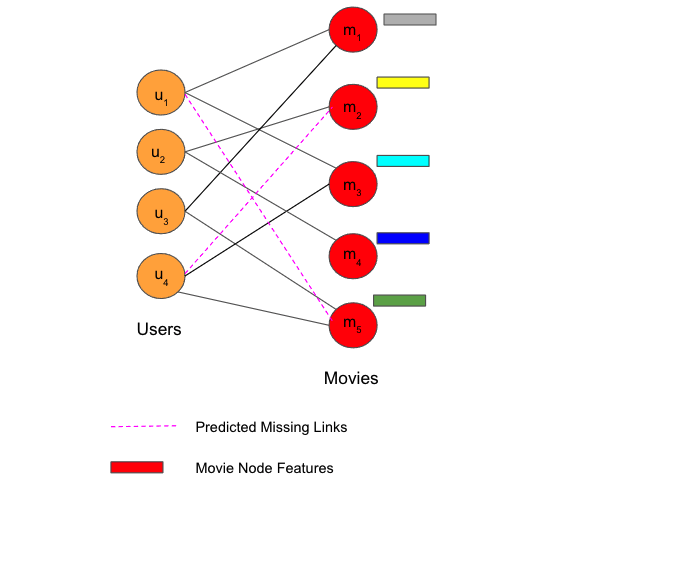

In [ ]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


In [ ]:
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [ ]:
model = Model(hidden_channels=32).to(device)

In [ ]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

In [ ]:
@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [ ]:
for epoch in range(1, 300):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

## Generate predictions and store them back to ArangoDB

Here, we will predict the new links between users and movies with the trained model. We will only select movies for a user whose predicting ratings are equal to 5.

In [ ]:
total_users = len(users)
total_movies = len(movies)
movie_recs = []
for user_id in tqdm(range(0, total_users)):
    user_row = torch.tensor([user_id] * total_movies)
    all_movie_ids = torch.arange(total_movies)
    edge_label_index = torch.stack([user_row, all_movie_ids], dim=0)
    pred = model(data.x_dict, data.edge_index_dict,
             edge_label_index)
    pred = pred.clamp(min=0, max=5)
    # we will only select movies for the user where the predicting rating is =5
    rec_movie_ids = (pred == 5).nonzero(as_tuple=True)
    top_ten_recs = [rec_movies for rec_movies in rec_movie_ids[0].tolist()[:10]] 
    movie_recs.append({'user': user_id, 'rec_movies': top_ten_recs})

Storing predictions back to ArangoDB

We will create a new collection name "Recommendation_Inferences" in ArangoDB to store movie recommendations for each of the user.

In [ ]:
# create a new collection named "Recommendation_Inferences" if it does not exist.
# This returns an API wrapper for "Recommendation_Inferences" collection.
if not movie_rec_db.has_collection("Recommendation_Inferences"):
    movie_rec_db.create_collection("Recommendation_Inferences", edge=True, replication_factor=3)
    


In [ ]:
def populate_movies_recommendations(movie_recs):
    batch = []

    BATCH_SIZE = 100
    batch_idx = 1
    index = 0
    rec_collection = movie_rec_db["Recommendation_Inferences"]
    for idx in tqdm(range(total_users)):
        insert_doc = {}
        to_insert = []
        user_id = movie_recs[idx]['user']
        movie_ids = movie_recs[idx]['rec_movies']
        
        for m_id in movie_ids:
            insert_doc = {
                           "_from":  ("Users" + "/" + str(user_id)),
                           "_to":    ("Movie" + "/" + str(m_id)),
                           "_rating": 5}
            to_insert.append(insert_doc)
        
        batch.extend(to_insert)
        index +=1
        last_record = (idx == (total_users - 1))
        if len(batch) > BATCH_SIZE:
          rec_collection.import_bulk(batch)
          batch = []   
        if last_record and len(batch) > 0:
          print("Inserting batch the last batch!")
          rec_collection.import_bulk(batch)

         #rec_collection.insert(insert_doc)

In [ ]:
populate_movies_recommendations(movie_recs)

### References

1. Working of [HETEROGENEOUS GRAPH LEARNING](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html).

2. The heterogeneous graph neural network code is inspired from PyG example [hetero_link_pred.py](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/hetero_link_pred.py)
